### 오토인코더를 이용하여 추신수 선수의 2015~2020년 MLB 인플레이 타구 분류

2015년부터 미국프로야구(MLB)는 타구와 선수를 카메라와 레이더를 이용하여 추적하는 스탯캐스트(Statcast)라는 시스템을 도입하였다. 스탯캐스트로 인해 타구의 속도, 발사각 등이 하나의 중요한 타격 지표가 되었으며, 선수들의 주력을 실시간으로 확인할 수 있게 되었다. 또한, 타구의 퀄리티를 정량적으로 판단할 수 있게 되었다. 
추신수 선수의 2015년 이후의 MLB 기록 역시 스탯캐스트를 통해 분석되어있다. MLB에서 운영하는 baseballsavant 사이트에 가면 추신수 선수 뿐만 아니라 메이저리그 모든 선수의 스탯케스트 관련 자료를 무료로 얻을 수 있다(https://baseballsavant.mlb.com/savant-player/shin-soo-choo-425783?stats=gamelogs-r-hitting-statcast&season=2020). 이곳에서 추신수 선수의 인플레이 타구 데이터 1603개를 얻었다. 타구속도(exit velocity), 발사각(launch angle), 타구거리(distance), 타구 방향(direction), 투구 구속(pitch velocity)에 따라 추신수 선수의 타격 결과가 어떻게 달라졌을지 오토인코더를 이용해 차원축소해보고자 한다.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

아직 baseballsavant에서 얻은 데이터는 오토인코더 차원축소를 하기에 적절하지 못하다. 타구속도와 발사각, 타구거리, 투구 구속은 그대로 사용하여도 되지만, 다른 지표들은 문자를 이용하여 표현되어있다.

타구방향은 '당겨 친 경우', '밀어 친 경우', '중앙으로 친 경우'의 3가지로 나뉘어져있다. 좌타자인 추신수 선수가 당겨 친 경우에 타구는 오른쪽으로 가고, 밀어 친 경우에는 왼쪽으로 간다. 이것이 정확하게 각도로 표현되어 있으면 좋겠지만 문자로 표현되어 있는 관계로 이를 숫자로 변경할 필요가 있었다. 그래서 당겨 친 경우엔 이를 숫자 1에 가깝고, 밀어 친 경우엔 숫자 0에 가깝게 하였다. 경기장을 5등분으로 나누었을 때(0-0.2, 0.2-0.4, 0.4-0.6, 0.6-0.8, 0.8-1.0) 추신수 선수는 7, 12, 26, 33, 21%의 비율로 타구를 보냈었다(Baseballsavant, 2021). 0-0.4를 밀어친 경우, 0.6-1.0을 당겨친 경우로 하여 해당하는 위치에 랜덤 숫자를 가지게 하였다. 가령, 당겨친 경우, 33/(33+21)%의 확률로 0.6-0.8 사이의 랜덤 값을, 21/(33+21)%의 확률로 0.8-1.0 사이의 랜덤 값을 가지게 하였다. 이와 같은 방식을 이용한 이유는 당겨친 경우를 1, 밀어친 경우를 0, 중앙으로 친 경우를 0.5로 데이터를 3진화하여 표현하면 나중에 차원축소를 하였을 때 plot 상에서 3개의 덩어리로 나뉘어지며 성능이 좋지 않았기 때문이다.

마지막으로 타구의 결과는 '아웃', '1루타', '2루타', '3루타', '홈런'으로 구분되는데, 아웃을 0, 1루타를 1, 2루타를 2, 3루타를 3, 홈런을 4로 표현하였다.

In [13]:
## 데이터 정제
df = pd.read_csv('choo_stat.csv') 
df

,Result,Exit_Velocity,Launch_Angle,Distance,Direction,Pitch,Pitch_Type
0,field_out,89.2,25,315,Pull,94.2,4-Seam Fastball
1,field_out,96.1,-3,27,Straightaway,81.6,Curveball
2,field_out,77.7,-22,5,Opposite,84.0,Changeup
3,field_out,78.6,-6,14,Straightaway,84.7,Changeup
4,field_out,66.6,-15,7,Pull,74.5,Curveball
...,...,...,...,...,...,...,...
1598,field_out,97.6,21,333,Straightaway,91.1,4-Seam Fastball
1599,field_out,88.2,14,172,Pull,94.6,Sinker
1600,single,100.3,15,241,Opposite,88.4,Sinker
1601,field_out,93.6,28,354,Straightaway,89.6,Sinker


In [32]:
# 인플레이 타구의 결과를 숫자로 표현
result_word = df.Result
def result_word2num(datas):
    result_num = []
    for data in range(len(datas)):
        if datas[data] == 'single':
            result_num.append(1.)
        elif datas[data] == 'double':
            result_num.append(2.)
        elif datas[data] == 'triple':
            result_num.append(3.)
        elif datas[data] == 'home_run':
            result_num.append(4.)
        else:
            result_num.append(0.)
    return result_num
result = result_word2num(result_word)
#print(result)


# 그대로 사용할 데이터
ev = df.Exit_Velocity
la = df.Launch_Angle
dist = df.Distance
pitch = df.Pitch

# 숫자 형태로 변형할 데이터
direct_word = df.Direction

## 타구 방향을 숫자로 표현
def direct_word2num(datas):
    direct_num = []
    for data in range(len(datas)):
        if datas[data] == 'Pull': # 당겨친 경우
            if np.random.rand() > 33/(33+21):
                direct_num.append(np.random.rand()/5 + 0.6)
            else:
                direct_num.append(np.random.rand()/5 + 0.8)
        elif datas[data] == 'Opposite': # 밀어친 경우
            if np.random.rand() > 12/(7+12):
                direct_num.append(np.random.rand()/5 + 0.2)
            else:
                direct_num.append(np.random.rand()/5 + 0.)
        else:
            direct_num.append(np.random.rand()/5 + 0.4) # 중앙으로 친 경우
    return direct_num
direct01 = direct_word2num(direct_word)
#print(direct01)

In [33]:
## 모든 데이터를 0에서 1사이의 수를 이용하여 표현
# '01'을 이름 뒤에 붙여 구분하였다.

ev01 = minmax_scale(ev)
#print(ev01)
la01 = minmax_scale(la)
#print(la01)
dist01 = minmax_scale(dist)
#print(dist01)
pitch01 = minmax_scale(pitch)
#print(pitch01)

## 타구속도, 발사각, 타구거리, 구속, 타구방향의 순서로 데이터 정리
choo_data = []
for i in range(len(result)):
    bat_data = ev01[i], la01[i], dist01[i], pitch01[i], direct01[i]
    choo_data.append(bat_data)
x = np.array(choo_data)
y = np.array(result)
label = y
print(x)
print(y)

[[0.74663677 0.66071429 0.66737288 0.85215054 0.9042334 ]
 [0.82399103 0.49404762 0.05720339 0.51344086 0.4312605 ]
 [0.617713   0.38095238 0.01059322 0.57795699 0.14870903]
 ...
 [0.87107623 0.60119048 0.51059322 0.69623656 0.11924448]
 [0.79596413 0.67857143 0.75       0.72849462 0.45504192]
 [0.19618834 0.29166667 0.00635593 0.84139785 0.0871515 ]]
[0. 0. 0. ... 1. 0. 1.]


이로써 오토인코더 차원 축소를 하기 위한 데이터 정제가 끝났고 아래와 같이 구현해 보았다. 1.타구속도 2.발사각 3.타구거리 4.구속 5.타구방향의 5개의 차원이 인코더와 디코더를 거쳐 다시 5개의 차원으로 돌아오는 형태이다. 교수님 수업자료의 코드를 참고하였다. 활성화 함수는 마지막에만 시그모이드를 사용하고 그 전에는 tanh를 사용하였다. ReLU도 사용해보았지만 tanh가 더 성능이 좋았다.  

In [34]:
batch_size = 250
tensor_x = torch.from_numpy(x.astype(np.float32))
tensor_y = torch.from_numpy(y.astype(np.float32))
choo_dataset = TensorDataset(tensor_x, tensor_y)
choo_dataset_loader = DataLoader(choo_dataset, batch_size, shuffle = True)

In [83]:
lr = 0.0001
epoch_num = 10000

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(5, 4),
            nn.Tanh(),
            nn.Linear(4, 3), 
            nn.Tanh(),
            nn.Linear(3, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 3),
            nn.Tanh(),
            nn.Linear(3, 4),
            nn.Tanh(),
            nn.Linear(4, 5),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder)
        return encoder, decoder

model = Autoencoder()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

In [84]:
for epoch in range(epoch_num):
    total_loss = 0
    for i, (x, y) in enumerate(choo_dataset_loader):
        enco, deco = model.forward(x)
        loss = loss_function(deco, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss
    if epoch % 1000 == 0:
        print('epoch: ' + str(epoch) + ', loss: ' + str(total_loss.item()))

epoch: 0, loss: 0.5915592908859253
epoch: 1000, loss: 0.1872781217098236
epoch: 2000, loss: 0.1448352038860321
epoch: 3000, loss: 0.10555454343557358
epoch: 4000, loss: 0.06595378369092941
epoch: 5000, loss: 0.06225251406431198
epoch: 6000, loss: 0.06047370657324791
epoch: 7000, loss: 0.05914318934082985
epoch: 8000, loss: 0.05910665541887283
epoch: 9000, loss: 0.05947396159172058


차원 축소를 통해 추신수 선수의 인플레이 타구 데이터를 z1과 z2로 표현가능하였다. 홈런 데이터는 비교적 한쪽에 뭉쳐있는 듯 보이지만 아웃 데이터는 곳곳에 퍼져있다. 아웃 데이터는 마치 2개의 영역으로 구분되는 듯한 경향을 보이는데(plot의 중앙 & 2루타 위치), 이는 땅볼 아웃과 플라이 아웃으로 구분 될 수 있을 것이라 추측한다. 2루타와 3루타 데이터는 잘 비교가 되지 않는다. 특히 3루타 데이터는 그 갯수가 적고 애초에 수비수의 실수와 같은 다른 변수가 작용하는 경우가 많기 때문에 잘 되지 않았다고 추정한다. 이외로도, 주로 아웃데이터들이 있는 곳에 1루타 데이터가 섞여 있는 경우가 여럿 보이는데, 이는 추신수 선수가 빠른 발을 이용하여 번트 안타나 내야 안타를 만든 것으로 추정한다.

결과적으로, 타구의 결과는 타구의 퀄리티 이외에도 수비수 실력, 타자의 주루 센스, 바람의 방향, 구장의 크기, 온도, 습도 등에도 영향을 받기 때문에 명확하게 분류가 잘 되지는 않았다. 아웃을 땅볼 아웃, 플라이 아웃, 직선타 아웃으로 구분하고, 타구의 회전 방향, 바람의 방향과 세기, 타자의 주루 속도(홈->1루로 가는 속도) 데이터를 추가적으로 이용한다면 더 좋은 결과를 얻을 것이라 기대한다.

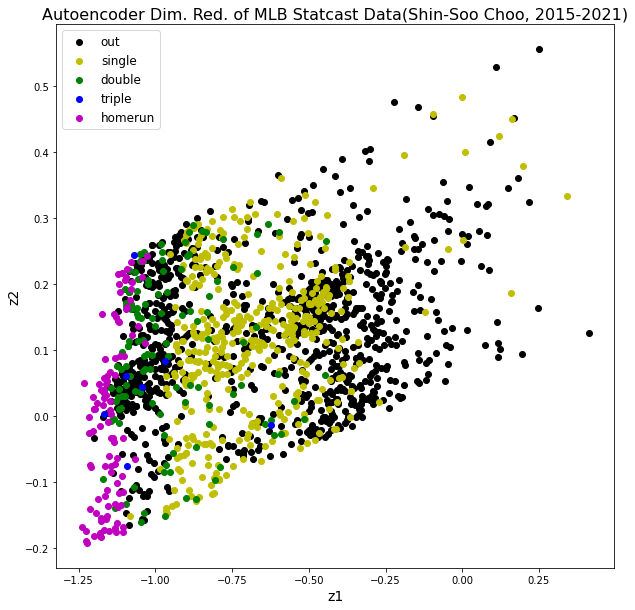

In [86]:
z1 = []
z2 = []
for i,  (x, y) in enumerate(choo_dataset):
    enco, deco = model(x)
    z = enco.data.numpy()
    z1.append(z[0])
    z2.append(z[1])

z1 = np.array(z1)
z2 = np.array(z2)

out = np.where(label == 0)
single = np.where(label == 1)
double = np.where(label == 2)
triple = np.where(label == 3)
homerun = np.where(label == 4)
#print(out)

plt.figure(figsize = (10, 10))
ax = plt.gca()
ax.set_facecolor('w')
plt.scatter(z1[out], z2[out], c = 'k')
plt.scatter(z1[single], z2[single], c = 'y')
plt.scatter(z1[double], z2[double], c = 'g')
plt.scatter(z1[triple], z2[triple], c = 'b')
plt.scatter(z1[homerun], z2[homerun], c = 'm')
plt.legend(['out', 'single', 'double', 'triple', 'homerun'], fontsize = 12)
plt.xlabel('z1', fontsize = 14)
plt.ylabel('z2', fontsize = 14)
plt.title('Autoencoder Dim. Red. of MLB Statcast Data(Shin-Soo Choo, 2015-2021)'\
         , fontsize = 16)

plt.show()